In [6]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import torch

print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")


Torch version: 2.5.1+cu121
CUDA available: True
Device name: NVIDIA RTX 500 Ada Generation Laptop GPU


In [7]:
AI_DIR = "dataset/ai"
REAL_DIR = "dataset/real"

assert os.path.isdir(AI_DIR), "AI dataset folder not found"
assert os.path.isdir(REAL_DIR), "Real dataset folder not found"

ai_images = [os.path.join(AI_DIR, f) for f in os.listdir(AI_DIR) if f.lower().endswith((".png", ".jpg", ".jpeg"))]
real_images = [os.path.join(REAL_DIR, f) for f in os.listdir(REAL_DIR) if f.lower().endswith((".png", ".jpg", ".jpeg"))]

print(f"AI images:   {len(ai_images)}")
print(f"Real images: {len(real_images)}")

# quick sanity check
assert len(ai_images) > 50, "Too few AI images"
assert len(real_images) > 50, "Too few real images"


AI images:   205
Real images: 204


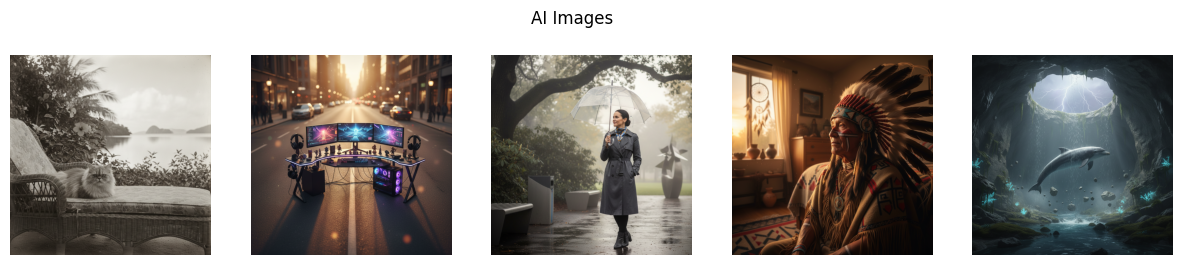

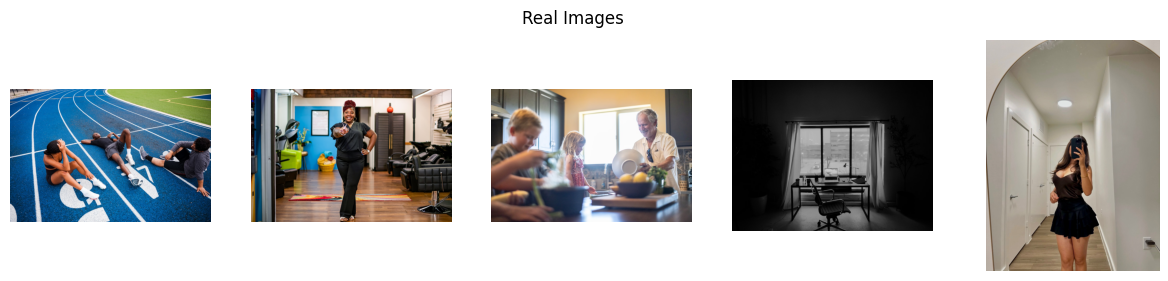

In [9]:
def show_samples(image_paths, title, n=5):
    samples = random.sample(image_paths, n)
    plt.figure(figsize=(15, 3))
    for i, path in enumerate(samples):
        img = Image.open(path).convert("RGB")
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

show_samples(ai_images, "AI Images")
show_samples(real_images, "Real Images")


In [10]:
def get_sizes(image_paths):
    sizes = []
    for p in image_paths:
        with Image.open(p) as img:
            sizes.append(img.size)  # (width, height)
    return sizes

ai_sizes = get_sizes(ai_images)
real_sizes = get_sizes(real_images)

print("AI size examples:", ai_sizes[:5])
print("Real size examples:", real_sizes[:5])

# minimum size check
min_ai = min(min(w, h) for w, h in ai_sizes)
min_real = min(min(w, h) for w, h in real_sizes)

print("Min AI dimension:", min_ai)
print("Min Real dimension:", min_real)

assert min_ai >= 224, "Some AI images are smaller than patch size"
assert min_real >= 224, "Some real images are smaller than patch size"


AI size examples: [(1080, 1669), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024)]
Real size examples: [(1201, 1600), (1080, 1350), (596, 800), (1080, 2408), (1080, 721)]
Min AI dimension: 558
Min Real dimension: 356


In [11]:
# Build (path, label) list

data = []

for p in ai_images:
    data.append({"path": p, "label": 1})

for p in real_images:
    data.append({"path": p, "label": 0})

print("Total images:", len(data))
print(
    "AI:",
    sum(1 for d in data if d["label"] == 1),
    "Real:",
    sum(1 for d in data if d["label"] == 0),
)


Total images: 409
AI: 205 Real: 204


In [12]:
random.seed(42)
random.shuffle(data)

In [13]:
total = len(data)

train_size = int(0.7 * total)
val_size = int(0.15 * total)

print("Train size:", train_size)
print("Val size:", val_size)
print("Test size:", total - train_size - val_size)


Train size: 286
Val size: 61
Test size: 62


In [14]:
train_data = data[:train_size]
val_data = data[train_size : train_size + val_size]
test_data = data[train_size + val_size :]

print("Train:", len(train_data))
print("Val:", len(val_data))
print("Test:", len(test_data))


Train: 286
Val: 61
Test: 62


In [15]:
train_paths = set(d["path"] for d in train_data)
val_paths = set(d["path"] for d in val_data)
test_paths = set(d["path"] for d in test_data)

assert train_paths.isdisjoint(val_paths)
assert train_paths.isdisjoint(test_paths)
assert val_paths.isdisjoint(test_paths)

print("✅ No overlap between splits")


✅ No overlap between splits


In [16]:
def label_stats(split, name):
    ai = sum(1 for d in split if d["label"] == 1)
    real = sum(1 for d in split if d["label"] == 0)
    print(f"{name}: AI={ai}, Real={real}")

label_stats(train_data, "Train")
label_stats(val_data, "Val")
label_stats(test_data, "Test")


Train: AI=143, Real=143
Val: AI=29, Real=32
Test: AI=33, Real=29


In [17]:
PATCH_SIZE = 224

In [18]:
from PIL import Image
import random

def sample_random_patch(image_path, patch_size=224):
    img = Image.open(image_path).convert("RGB")
    w, h = img.size

    if w < patch_size or h < patch_size:
        raise ValueError("Image smaller than patch size")

    x = random.randint(0, w - patch_size)
    y = random.randint(0, h - patch_size)

    patch = img.crop((x, y, x + patch_size, y + patch_size))
    return patch


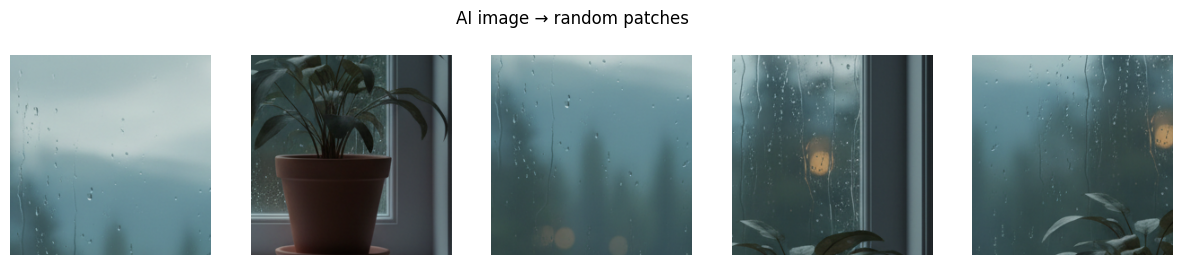

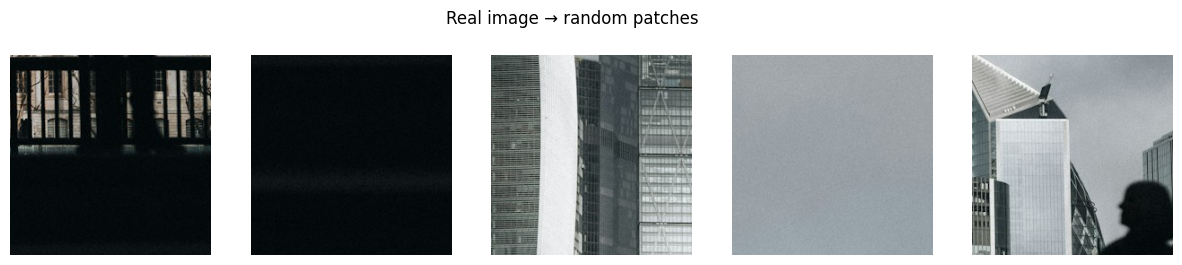

In [30]:
import matplotlib.pyplot as plt

def show_patches(image_path, title, n=5):
    plt.figure(figsize=(15, 3))
    for i in range(n):
        patch = sample_random_patch(image_path)
        plt.subplot(1, n, i + 1)
        plt.imshow(patch)
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

# pick one sample from each
show_patches(random.choice(ai_images), "AI image → random patches")
show_patches(random.choice(real_images), "Real image → random patches")


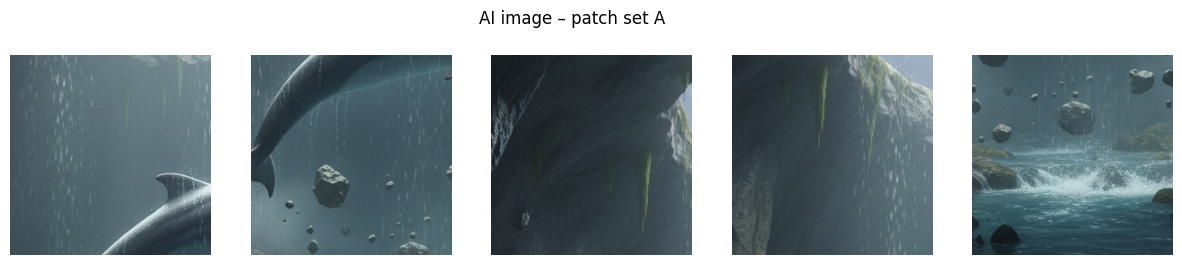

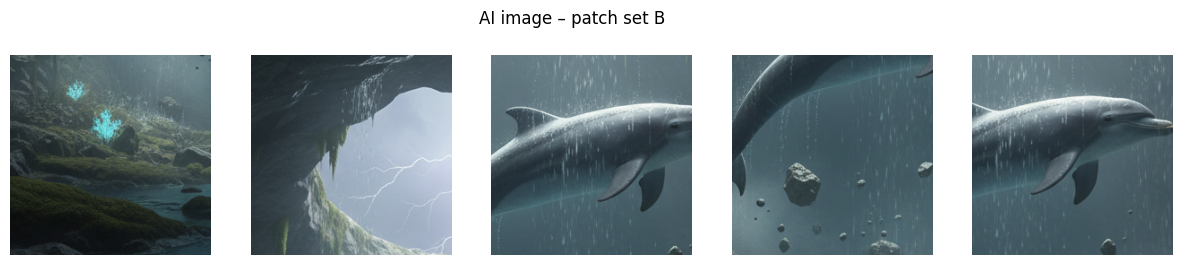

In [31]:
img_path = random.choice(ai_images)

show_patches(img_path, "AI image – patch set A")
show_patches(img_path, "AI image – patch set B")


In [32]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms


In [33]:
basic_transform = transforms.Compose([
    transforms.ToTensor(),  # converts to [0,1] and CHW
])

In [34]:
class PatchDataset(Dataset):
    def __init__(self, data, patch_size=224, transform=None, patches_per_image=1):
        """
        data: list of dicts -> {"path": ..., "label": ...}
        patch_size: size of square patch
        transform: torchvision transform applied to patch
        patches_per_image: how many patches we sample per image per epoch
        """
        self.data = data
        self.patch_size = patch_size
        self.transform = transform
        self.patches_per_image = patches_per_image

    def __len__(self):
        # each image contributes multiple samples
        return len(self.data) * self.patches_per_image

    def __getitem__(self, idx):
        # map global idx to image idx
        image_idx = idx // self.patches_per_image
        item = self.data[image_idx]

        image_path = item["path"]
        label = item["label"]

        # sample one random patch
        patch = sample_random_patch(image_path, self.patch_size)

        if self.transform:
            patch = self.transform(patch)

        return patch, torch.tensor(label, dtype=torch.float32)


In [35]:
TRAIN_PATCHES_PER_IMAGE = 15
VAL_PATCHES_PER_IMAGE = 5

train_dataset = PatchDataset(
    train_data,
    patch_size=PATCH_SIZE,
    transform=basic_transform,
    patches_per_image=TRAIN_PATCHES_PER_IMAGE,
)

val_dataset = PatchDataset(
    val_data,
    patch_size=PATCH_SIZE,
    transform=basic_transform,
    patches_per_image=VAL_PATCHES_PER_IMAGE,
)

print("Train samples:", len(train_dataset))
print("Val samples:", len(val_dataset))


Train samples: 4290
Val samples: 305


Patch shape: torch.Size([3, 224, 224])
Label: tensor(1.)


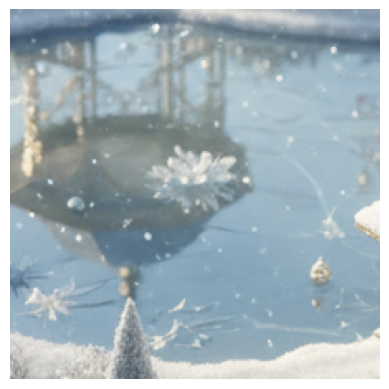

In [41]:
patch, label = train_dataset[0]

print("Patch shape:", patch.shape)
print("Label:", label)

plt.imshow(patch.permute(1, 2, 0))
plt.axis("off")
plt.show()


In [42]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),

    # simulate resize / screenshot artifacts
    transforms.RandomResizedCrop(
        PATCH_SIZE,
        scale=(0.7, 1.0),
        ratio=(0.9, 1.1)
    ),

    # slight color & lighting variations
    transforms.ColorJitter(
        brightness=0.15,
        contrast=0.15,
        saturation=0.1,
        hue=0.02
    ),

    transforms.ToTensor(),
])


In [43]:
val_transform = transforms.Compose([
    transforms.Resize(PATCH_SIZE),
    transforms.CenterCrop(PATCH_SIZE),
    transforms.ToTensor(),
])


In [44]:
train_dataset = PatchDataset(
    train_data,
    patch_size=PATCH_SIZE,
    transform=train_transform,
    patches_per_image=TRAIN_PATCHES_PER_IMAGE,
)

val_dataset = PatchDataset(
    val_data,
    patch_size=PATCH_SIZE,
    transform=val_transform,
    patches_per_image=VAL_PATCHES_PER_IMAGE,
)


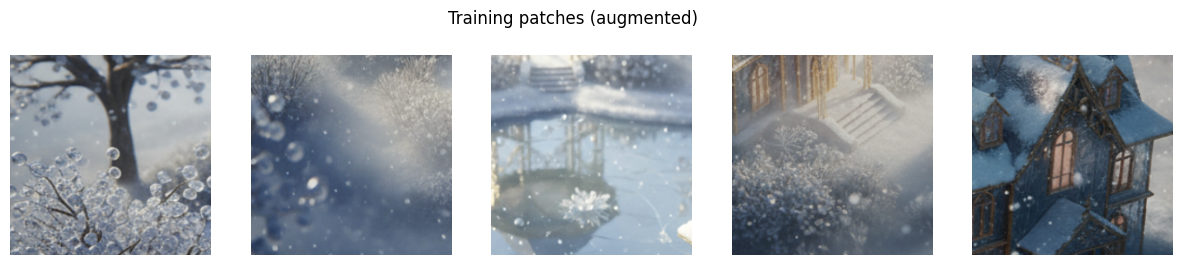

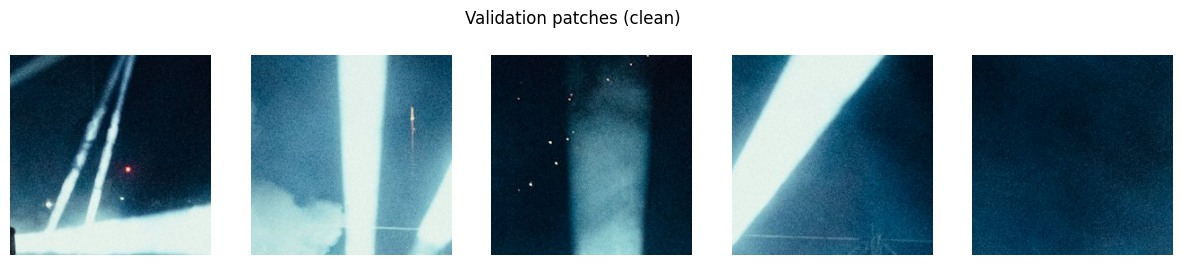

In [45]:
def show_augmented(dataset, title, n=5):
    plt.figure(figsize=(15, 3))
    for i in range(n):
        patch, label = dataset[i]
        plt.subplot(1, n, i + 1)
        plt.imshow(patch.permute(1, 2, 0))
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

show_augmented(train_dataset, "Training patches (augmented)")
show_augmented(val_dataset, "Validation patches (clean)")


In [46]:
import torch
import torch.nn as nn
import torchvision.models as models


In [47]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\hemant.acharya/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:02<00:00, 19.3MB/s]


In [48]:
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)


In [49]:
for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True


In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print("Using device:", device)


Using device: cuda


In [51]:
patch, label = train_dataset[0]
patch = patch.unsqueeze(0).to(device)  # add batch dimension

with torch.no_grad():
    output = model(patch)

print("Model output shape:", output.shape)


Model output shape: torch.Size([1, 1])


In [58]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))


Train batches: 135
Val batches: 10


In [59]:
criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(
    model.fc.parameters(),  # only train classifier head
    lr=1e-3
)


In [60]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0

    for patches, labels in loader:
        patches = patches.to(device)
        labels = labels.to(device).unsqueeze(1)  # shape [B, 1]

        optimizer.zero_grad()

        outputs = model(patches)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * patches.size(0)

    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss


In [61]:
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_outputs = []
    all_labels = []

    with torch.no_grad():
        for patches, labels in loader:
            patches = patches.to(device)
            labels = labels.to(device).unsqueeze(1)

            outputs = model(patches)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * patches.size(0)
            all_outputs.append(outputs.cpu())
            all_labels.append(labels.cpu())

    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss, torch.cat(all_outputs), torch.cat(all_labels)


In [62]:
NUM_EPOCHS = 5

for epoch in range(NUM_EPOCHS):
    train_loss = train_one_epoch(
        model, train_loader, optimizer, criterion, device
    )

    val_loss, _, _ = evaluate(
        model, val_loader, criterion, device
    )

    print(
        f"Epoch {epoch+1}/{NUM_EPOCHS} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f}"
    )


Epoch 1/5 | Train Loss: 0.5431 | Val Loss: 0.5024
Epoch 2/5 | Train Loss: 0.3980 | Val Loss: 0.4041
Epoch 3/5 | Train Loss: 0.3519 | Val Loss: 0.3936
Epoch 4/5 | Train Loss: 0.3107 | Val Loss: 0.4788
Epoch 5/5 | Train Loss: 0.3147 | Val Loss: 0.3311


In [64]:
import torch
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_curve, auc


In [65]:
# run evaluation again to capture outputs
val_loss, val_logits, val_labels = evaluate(
    model, val_loader, criterion, device
)

# convert logits → probabilities
val_probs = torch.sigmoid(val_logits).numpy()
val_labels_np = val_labels.numpy()

print("Validation loss:", val_loss)


Validation loss: 0.38028027962465755


In [69]:
roc_auc = roc_auc_score(val_labels_np, val_probs)
print("Patch-level ROC-AUC:", roc_auc)

Patch-level ROC-AUC: 0.9242672413793102


In [70]:
val_preds = (val_probs > 0.5).astype(int)
acc = accuracy_score(val_labels_np, val_preds)
print("Patch-level accuracy:", acc)


Patch-level accuracy: 0.839344262295082


In [71]:
precision, recall, _ = precision_recall_curve(val_labels_np, val_probs)
pr_auc = auc(recall, precision)

print("Patch-level PR-AUC:", pr_auc)


Patch-level PR-AUC: 0.9298734804409075


In [72]:
import numpy as np

def infer_image(
    model,
    image_path,
    device,
    num_patches=30,
    patch_size=224,
    transform=val_transform,
    aggregation="percentile",
    percentile=90
):
    model.eval()
    probs = []

    with torch.no_grad():
        for _ in range(num_patches):
            patch = sample_random_patch(image_path, patch_size)
            patch = transform(patch).unsqueeze(0).to(device)

            logit = model(patch)
            prob = torch.sigmoid(logit).item()
            probs.append(prob)

    probs = np.array(probs)

    if aggregation == "mean":
        score = probs.mean()
    elif aggregation == "percentile":
        score = np.percentile(probs, percentile)
    else:
        raise ValueError("Unknown aggregation method")

    return score, probs


In [73]:
# test a few AI images
for p in random.sample(ai_images, 3):
    score, _ = infer_image(model, p, device)
    print("AI image score:", round(score, 3))

print("-" * 40)

# test a few real images
for p in random.sample(real_images, 3):
    score, _ = infer_image(model, p, device)
    print("Real image score:", round(score, 3))


AI image score: 0.995
AI image score: 0.949
AI image score: 0.975
----------------------------------------
Real image score: 0.608
Real image score: 0.475
Real image score: 0.375


In [74]:
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

def evaluate_image_level(
    model,
    data,
    device,
    num_patches=30,
    aggregation="percentile",
    percentile=90
):
    scores = []
    labels = []

    for item in tqdm(data):
        score, _ = infer_image(
            model,
            item["path"],
            device,
            num_patches=num_patches,
            aggregation=aggregation,
            percentile=percentile
        )
        scores.append(score)
        labels.append(item["label"])

    return np.array(scores), np.array(labels)


In [75]:
image_scores, image_labels = evaluate_image_level(
    model,
    test_data,
    device,
    num_patches=30,
    aggregation="percentile",
    percentile=90
)

image_roc_auc = roc_auc_score(image_labels, image_scores)
print("Image-level ROC-AUC:", image_roc_auc)


100%|██████████| 62/62 [02:09<00:00,  2.09s/it]

Image-level ROC-AUC: 1.0


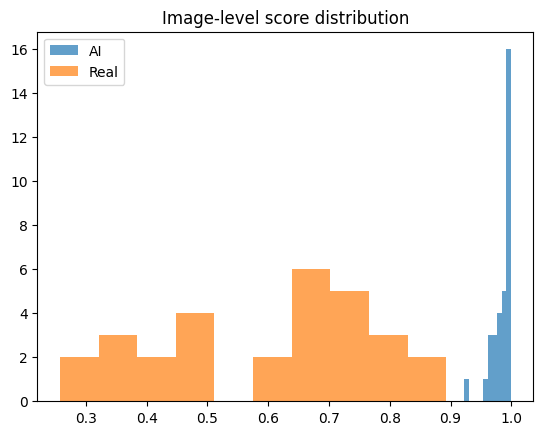

In [76]:
import matplotlib.pyplot as plt

plt.hist(image_scores[image_labels == 1], bins=10, alpha=0.7, label="AI")
plt.hist(image_scores[image_labels == 0], bins=10, alpha=0.7, label="Real")
plt.legend()
plt.title("Image-level score distribution")
plt.show()


In [77]:
image_scores_75, image_labels = evaluate_image_level(
    model,
    test_data,
    device,
    num_patches=30,
    aggregation="percentile",
    percentile=75
)

roc_auc_75 = roc_auc_score(image_labels, image_scores_75)
print("Image ROC-AUC (75th percentile):", roc_auc_75)


100%|██████████| 62/62 [02:20<00:00,  2.27s/it]

Image ROC-AUC (75th percentile): 0.9979101358411704


In [78]:
image_scores_10, image_labels = evaluate_image_level(
    model,
    test_data,
    device,
    num_patches=10,
    aggregation="percentile",
    percentile=90
)

roc_auc_10 = roc_auc_score(image_labels, image_scores_10)
print("Image ROC-AUC (10 patches):", roc_auc_10)


100%|██████████| 62/62 [00:48<00:00,  1.27it/s]

Image ROC-AUC (10 patches): 0.9968652037617555


In [ ]:
import torch
import json

MODEL_PATH = "models/layer_b_model.pt"
CONFIG_PATH = "models/layer_b_config.json"

# save weights
torch.save(model.state_dict(), MODEL_PATH)

# save config (important!)
config = {
    "architecture": "resnet18",
    "input_size": 224,
    "num_patches": 30,
    "aggregation": "percentile",
    "percentile": 90,
    "label_map": { "0": "real", "1": "ai" }
}

with open(CONFIG_PATH, "w") as f:
    json.dump(config, f, indent=2)

print("✅ Model and config saved")


✅ Model and config saved
